# Qiskit Exercise List 2 Solutions

In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import ZGate, MCMTGate, QFT
from qiskit_aer import AerSimulator
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram

import numpy as np
import pandas as pd
from fractions import Fraction

## Exercise 1

Consider an unstructured list of $2^6 = 64$ elements, that has $3$ marked elements that we wish to identify, encoded in the oracle circuit defined below. The goal is to find the marked states using Grover's algorithm.

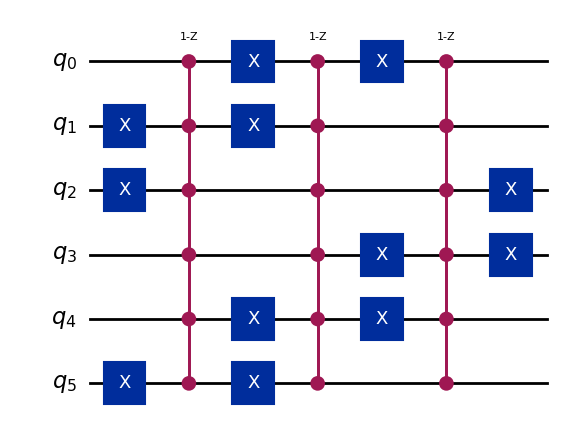

In [16]:
oracle = QuantumCircuit(6)
oracle.x(1)
oracle.x(2)
oracle.x(5)
oracle.compose(MCMTGate(ZGate(), 5, 1), inplace=True)
oracle.x(0)
oracle.x(1)
oracle.x(4)
oracle.x(5)
oracle.compose(MCMTGate(ZGate(), 5, 1), inplace=True)
oracle.x(0)
oracle.x(3)
oracle.x(4)
oracle.compose(MCMTGate(ZGate(), 5, 1), inplace=True)
oracle.x(2)
oracle.x(3)
oracle.draw('mpl')

(a) How many Grover's operations are needed to find the marked element?

In [17]:
# Fill the following variables with the appropriate values

# Number of qubits
n = 6

# Number of elements in the list
M = 3

# Number of marked elements
N = 2**n

# Number of Grover's iterations
t = int((np.pi/(4*np.arcsin((np.sqrt(M/N)))) ) - 1/2)
print(t)

3


(b) Define a function that implements the Diffuser Operator.

In [18]:
def diffuser(n):
    qc = QuantumCircuit(n)

    qc.h(range(n))
    qc.x(range(n))
    qc.compose(MCMTGate(ZGate(), n - 1, 1), inplace=True)
    qc.x(range(n))
    qc.h(range(n))
    
    # Transform the circuit into a Gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

(c) Implement Grover's algorithm using the oracle circuit and the Diffuser Operator. Obtain the marked states by measuring the circuit with the `AerSimulator()` backend using $100$ shots.

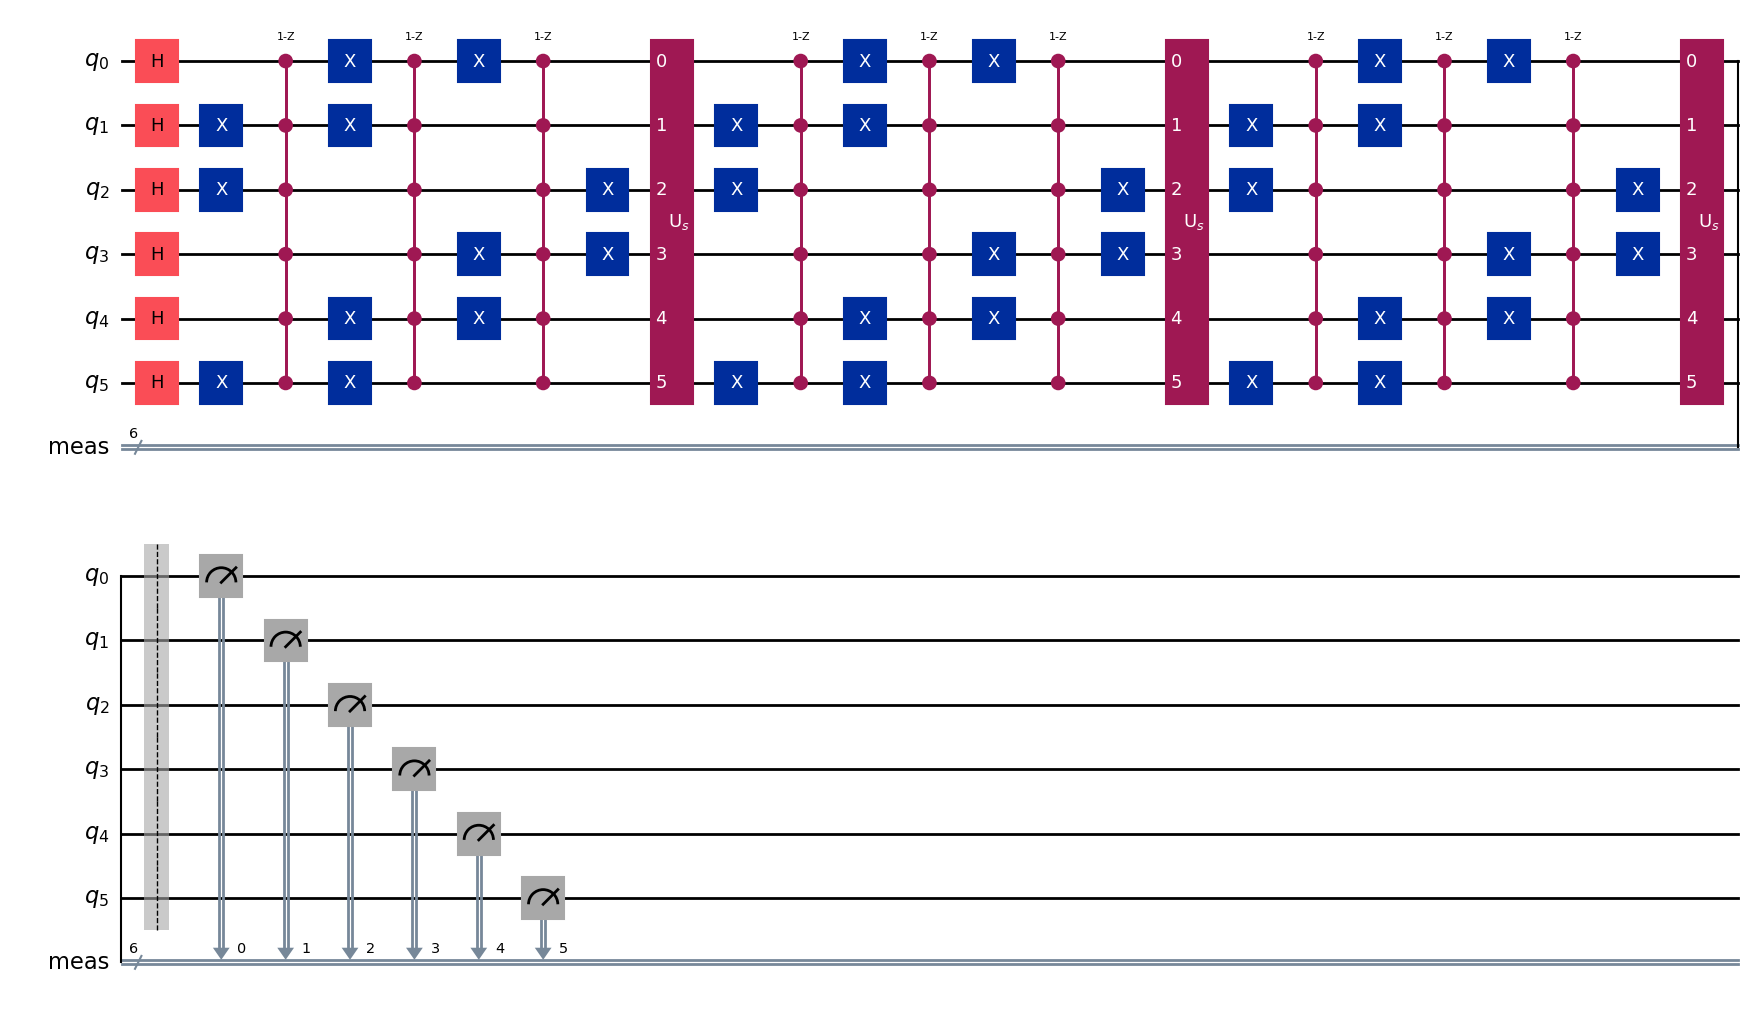

In [19]:
grover_circuit = QuantumCircuit(n)

# Hadamard Transform
grover_circuit.h(range(n))

for i in range(t):
    grover_circuit.compose(oracle, inplace=True)
    grover_circuit.compose(diffuser(n), inplace=True)

grover_circuit.measure_all()
grover_circuit.draw('mpl')

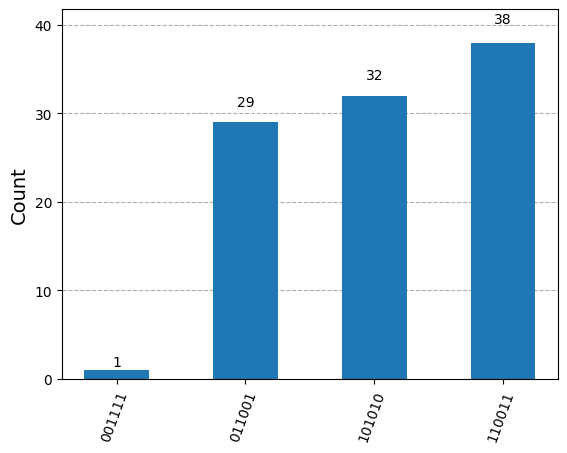

In [20]:
backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
grover_trans = pm.run(grover_circuit)
result = backend.run(grover_trans, shots=100).result()
counts = result.get_counts()
plot_histogram(counts)

The marked states correspond to:

- $011001$
- $101010$
- $110011$

## Exercise 2

The goal of this exercise is to obtain the multiplicative order of $4$ modulo $27$ using Quantum Phase Estimation. For this, consider the following unitary gate, which implements the following transformation:

$$U|y\rangle \equiv |by \bmod N \rangle,$$

given by the code below.

In [21]:
from qiskit.circuit.library import UnitaryGate

def mod_mult_gate(b,N):
    if np.gcd(b,N)>1:
        print(f"Error: gcd({b},{N}) > 1")
    else:
        n = int(np.floor(np.log2(N-1)) + 1)
        U = np.full((2**n,2**n),0)
        for x in range(N): U[b*x % N][x] = 1
        for x in range(N,2**n): U[x][x] = 1
        G = UnitaryGate(U)
        G.name = f"M_{b}"
        return G

(a) Check the lecture notes, and find the number of qubits needed for preparing the initial state $|0\rangle$ and the number of qubits needed for the ancillary register.

In [22]:
a = 4
N = 27

# Initial state size
m = int(np.ceil(np.log2(N)))

# Ancillary register size
n = int(2*np.ceil(np.log2(N))) + 1

print(m)
print(n)

5
11


(b) Construct the quantum circuit that solves the order-finding problem using QPE. 

Hint 1: Notice that the gate defined in `mod_mult_gate` does not include controls!

Hint 2: In the lecture notes, we implemented the cascade of controlled unitaries through the following loop: `for _ in range(2**index)`. For a higher number of qubits (as this case is), the implementation through this method becomes inefficient. To amend that, implement the controlled unitaries using the [`pow`](https://docs.python.org/3/library/functions.html#pow) function (to be used as first argument for the `mod_mult_gate` function).

$$U|1\rangle = |a \cdot 1 \bmod N \rangle,$$

$$U^{2}|1\rangle = U|a \bmod N \rangle = |a^2 \bmod N \rangle,$$

$$U^{2^j}|1\rangle = U^{2^j - 1}|a \bmod N \rangle = |a^{2^j} \bmod N \rangle = | \text{pow}(a, 2^j, 27) \rangle$$

In [23]:
# Usage example:

for j in range(n):
    y = 2**j
    print(f"a^{y} modulo {N} = {pow(a, y, N)}")

a^1 modulo 27 = 4
a^2 modulo 27 = 16
a^4 modulo 27 = 13
a^8 modulo 27 = 7
a^16 modulo 27 = 22
a^32 modulo 27 = 25
a^64 modulo 27 = 4
a^128 modulo 27 = 16
a^256 modulo 27 = 13
a^512 modulo 27 = 7
a^1024 modulo 27 = 22


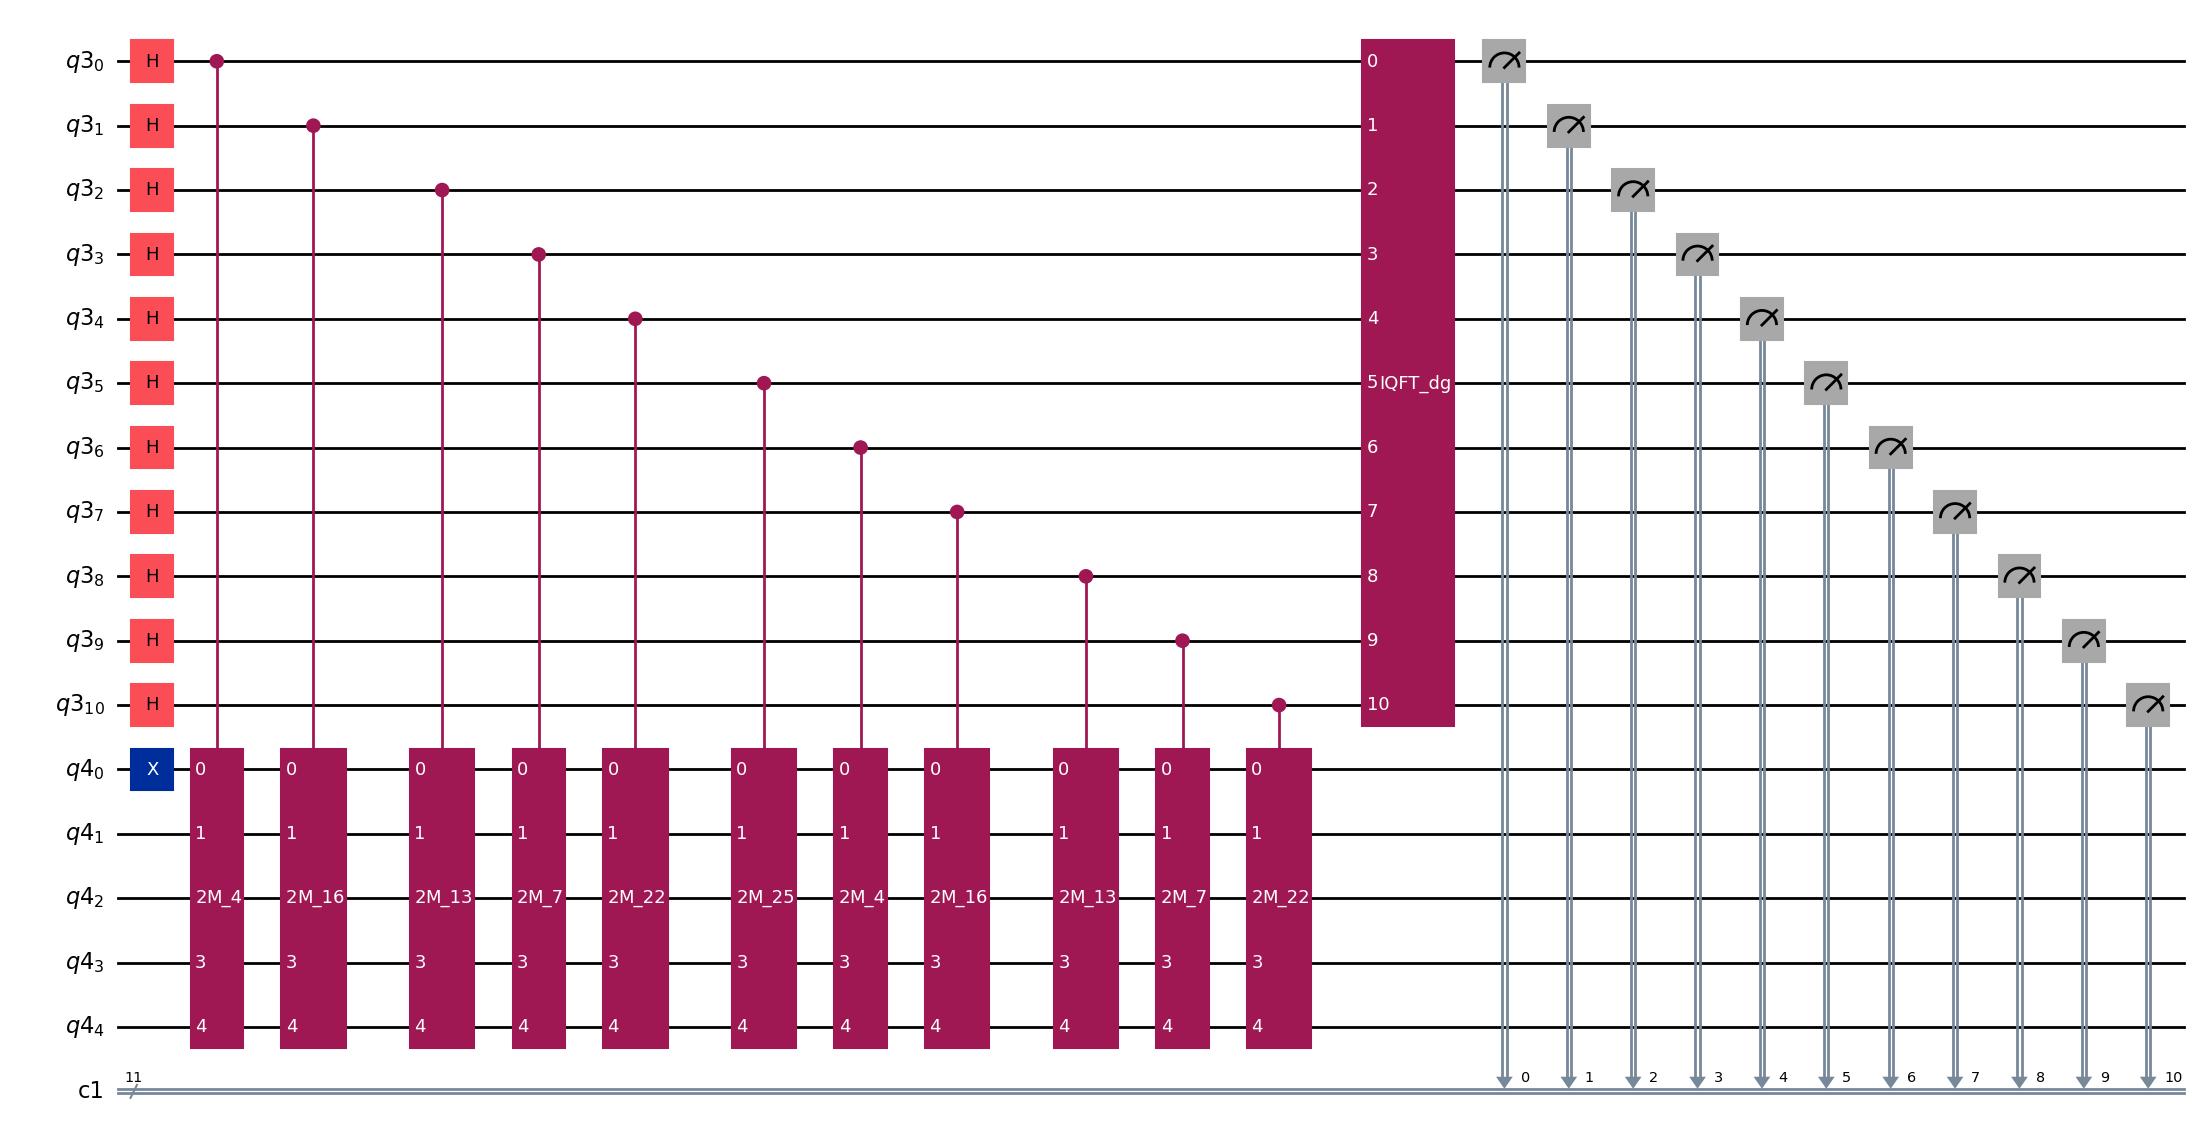

In [24]:
control_register = QuantumRegister(n)
output_register = ClassicalRegister(n)
target_register = QuantumRegister(m)

order_fact_qc = QuantumCircuit(control_register, target_register, output_register)

# Prepare |ψ> = |1> = |0001>
order_fact_qc.x(target_register[0])

# Do phase estimation
order_fact_qc.h(control_register)

for k, qubit in enumerate(control_register):
   b = pow(a,2**k,N)
   order_fact_qc.compose(mod_mult_gate(b,N).control(),
                       qubits=[qubit] + list(target_register),
                       inplace=True)


order_fact_qc.compose(QFT(n, inverse=True), range(n), inplace=True)

order_fact_qc.measure(control_register, output_register)
order_fact_qc.draw('mpl', fold=-1)

(c) Execute the circuit with the `AerSimulator()` backend using $100$ shots. Use the functions defined on the lectures notes (modify them when needed!) to get different guesses for the multiplicative order. Explain which guess is the correct one, and justify why some may be incorrect ones.

In [25]:
# Run the circuit on the backend and get the counts

pm = generate_preset_pass_manager(backend=backend)
t_qc = pm.run(order_fact_qc)

answer = backend.run(t_qc, backend=backend, shots=100).result().get_counts()

In [26]:
# Get the measured phases

rows, measured_phases = [], []
for output in answer:
    decimal = int(output, 2)                      # Binary string to decimal
    phase = decimal/(2**n)                        # Phase value
    measured_phases.append(phase)
    
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n} = {phase:.2f}"])
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                 Register Output             Phase
0   10101010101(bin) = 1365(dec)  1365/2048 = 0.67
1   11100011100(bin) = 1820(dec)  1820/2048 = 0.89
2    01010101011(bin) = 683(dec)   683/2048 = 0.33
3   10001110010(bin) = 1138(dec)  1138/2048 = 0.56
4    00000000000(bin) =   0(dec)     0/2048 = 0.00
5    00011100100(bin) = 228(dec)   228/2048 = 0.11
6    00011100011(bin) = 227(dec)   227/2048 = 0.11
7    01110001110(bin) = 910(dec)   910/2048 = 0.44
8   11100011101(bin) = 1821(dec)  1821/2048 = 0.89
9    00111000111(bin) = 455(dec)   455/2048 = 0.22
10  11000111001(bin) = 1593(dec)  1593/2048 = 0.78
11  10001110001(bin) = 1137(dec)  1137/2048 = 0.56
12  10101010100(bin) = 1364(dec)  1364/2048 = 0.67
13   00011100010(bin) = 226(dec)   226/2048 = 0.11
14   01010101101(bin) = 685(dec)   685/2048 = 0.33
15  11100011110(bin) = 1822(dec)  1822/2048 = 0.89
16   01010101010(bin) = 682(dec)   682/2048 = 0.33
17   00011100000(bin) = 224(dec)   224/2048 = 0.11
18  10101010110(bin) = 1366(dec

In [27]:
# Get the different guesses for r. Remember to change the limit_denominator value to 27

rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(27)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

       Phase Fraction  Guess for r
0   0.666504      2/3            3
1   0.888672      8/9            9
2   0.333496      1/3            3
3   0.555664      5/9            9
4   0.000000      0/1            1
5   0.111328      1/9            9
6   0.110840      1/9            9
7   0.444336      4/9            9
8   0.889160      8/9            9
9   0.222168      2/9            9
10  0.777832      7/9            9
11  0.555176      5/9            9
12  0.666016      2/3            3
13  0.110352      1/9            9
14  0.334473      1/3            3
15  0.889648      8/9            9
16  0.333008      1/3            3
17  0.109375      1/9            9
18  0.666992      2/3            3
19  0.108398      1/9            9
20  0.556152      5/9            9
21  0.660156    17/26           26
22  0.222656      2/9            9
23  0.887695      8/9            9


- If the obtained guess is $r = 1$, that means that we obtained the phase $0$ (i.e. we measured the state $s=0$), which contains no information. Therefore, it is incorrect.
- If the obtained guess is $r = 3$, we can observe that the measured $s$ and $r$ are not coprimes, therefore it is incorrect.
- If the obtained guess is $r = 9$, we notice that the both the measured $s$ and $r$ are coprimes, so it is a valid guess. Given that this is the lowest guess, it must be the correct one.
- If the obtained guess is $r > 9$, then we know from the previous argument that it is incorrect.